# Упражнение kNN (k-Nearest Neighbor)

kNN-классификатор состоит из двух этапов:

- Во время обучения классификатор просто запоминает обучающие данные.
- Во время тестирования kNN классифицирует каждое тестовое изображение, сравнивая со всеми обучающими изображениями и передавая метки k наиболее похожих обучающих примеров.
- Значение k кросс-валидируется.

В этом упражнении вы реализуете эти шаги и поймёте основной пайплайн классификации изображений, кросс-валидацию и приобретёте навыки написания эффективного векторизованного кода.

In [1]:
# Запустим установочный код для этого ноутбука.

import os
import random

import numpy as np
import matplotlib.pyplot as plt

from cs231n.data_utils import load_CIFAR10

# Немного магии, позволяющей отображать matplotlib-рисунки в ноутбуке, а не в новом окне.
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # установим размер графиков по умолчанию
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# Ещё немного магии, чтобы ноутбук перезагрузил внешние модули Python;
# Смотри http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Загрузим необработанные данные CIFAR-10.
cifar10_dir = os.path.join("cs231n", "datasets", "cifar-10-batches-py")

# Очистка переменных для предотвращения многократной загрузки данных (что может вызвать проблемы с памятью)
try:
    del X_train, y_train
    del X_test, y_test
    print("Ранее загруженные данные очищены.")
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# В качестве проверки работоспособности мы распечатываем размер обучающих и тестовых данных.
print("Форма обучающих данных:", X_train.shape)
print("Форма обучающих меток: ", y_train.shape)
print("Форма тестовых данных: ", X_test.shape)
print("Форма тестовых меток:  ", y_test.shape)

Форма обучающих данных: (50000, 32, 32, 3)
Форма обучающих меток:  (50000,)
Форма тестовых данных:  (10000, 32, 32, 3)
Форма тестовых меток:   (10000,)


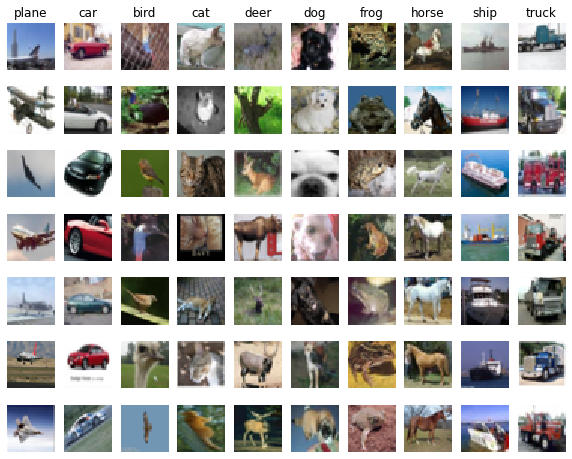

In [3]:
# Визуализируем несколько примеров из набора данных.
# Мы показываем несколько примеров обучающих изображений из каждого класса.
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype("uint8"))
        plt.axis("off")
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Подвыборка данных для более эффективного выполнения кода в этом упражнении
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Преобразуем данные изображения в строки
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [5]:
from cs231n.classifiers import KNearestNeighbor

# Создадим экземпляр kNN-классификатора.
# Помните, что обучение kNN-классификатора является пустым занятием:
# классификатор просто запоминает данные и не выполняет дальнейшую обработку.  
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

Теперь мы хотели бы классифицировать тестовые данные с помощью kNN-классификатора. Напомним, что мы можем разбить этот процесс на два этапа: 

1. Сначала мы должны вычислить расстояния между всеми тестовыми примерами и всеми обучающими примерами.
2. Учитывая эти расстояния, для каждого тестового примера мы находим k ближайших примеров и заставляем их голосовать за метку.

Начнём с вычисления матрицы расстояний между всеми обучающими и тестовыми примерами. Например, если есть **Ntr** обучающих примеров и **Nte** тестовых примеров, на этом этапе должна получиться матрица **Nte x Ntr**, где каждый (i, j) элемент - это расстояние между i-м тестовым и j-м обучающим примером.

**Примечание: Для трёх вычислений расстояния, которые мы требуем от вас реализовать в этом ноутбуке, нельзя использовать функцию np.linalg.norm(), которую предоставляет numpy.**

Сначала откройте `cs231n/classifiers/k_nearest_neighbor.py` и реализуйте функцию `compute_distances_two_loops`, которая использует (очень неэффективный) двойной цикл по всем парам (test, train) примеров и вычисляет матрицу расстояний по одному элементу за раз.

In [6]:
# Протестируйте свою реализацию:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


Мы можем визуализировать матрицу расстояний: каждая строка представляет собой отдельный тестовый пример и его расстояния до обучающих примеров.

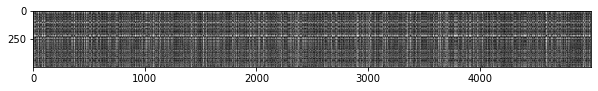

In [7]:
plt.imshow(dists, interpolation="none")
plt.show()

**Вопрос 1** 

Обратите внимание на структурированные паттерны в матрице расстояний, где некоторые строки или столбцы видны ярче. (Обратите внимание, что в цветовой схеме по умолчанию чёрный означает малые расстояния, а белый - большие.)

- Что в данных является причиной отчётливо ярких строк?
- Что вызывает столбцы?

**Мой ответ 1**

- Яркие строки говорят о том, что в тестовых данных есть точки, которые находятся вне сгустка облака обучающих точек.
- Яркие столбцы же говорят об обратном: что в обучающих данных есть точки, которые находятся вне сгустка облака тестовых точек.

Теперь реализуйте функцию `predict_labels` и запустите приведённый ниже код:

In [10]:
# Мы используем k = 1 (Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Вычислим и напечатаем долю правильно предсказанных примеров
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print("Got %d/%d correct => точность: %f" % (num_correct, num_test, accuracy))

Got 137/500 correct => точность: 0.274000


Вы должны ожидать около `27%` точности. Теперь давайте попробуем большее `k`, скажем `k = 5`:

In [12]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print("Got %d/%d correct => точность: %f" % (num_correct, num_test, accuracy))

Got 139/500 correct => точность: 0.278000


Вы должны ожидать немного лучшей производительности, чем при `k = 1`.

**Вопрос 2**

Мы также можем использовать другие метрики, такие как L1-расстояние.
Для значений пикселя $p_{ij}^{(k)}$ в позиции $(i,j)$ некоторого изображения $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

In [ ]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord="fro")
print("One loop difference was: %f" % (difference, ))
if difference < 0.001:
    print("Good! The distance matrices are the same")
else:
    print("Uh-oh! The distance matrices are different")

In [ ]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord="fro")
print("No loop difference was: %f" % (difference, ))
if difference < 0.001:
    print("Good! The distance matrices are the same")
else:
    print("Uh-oh! The distance matrices are different")

In [ ]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print("Two loop version took %f seconds" % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print("One loop version took %f seconds" % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print("No loop version took %f seconds" % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print("k = %d, accuracy = %f" % (k, accuracy))

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title("Cross-validation on k")
plt.xlabel("k")
plt.ylabel("Cross-validation accuracy")
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print("Got %d / %d correct => accuracy: %f" % (num_correct, num_test, accuracy))

**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$

